In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [5]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data(random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_separable_data(random_state=123456)

## Hinge loss

### Primal formulation

In [6]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import linear
        
        dual_svc = DualSVC(loss=hinge, kernel=linear, C=svc.C, fit_intercept=svc.fit_intercept, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, dual_svc.obj(dual_svc.alphas_))
        # (f_i - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), f_star)
        
    return {'accuracy': svc.score(X, y),
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch,
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

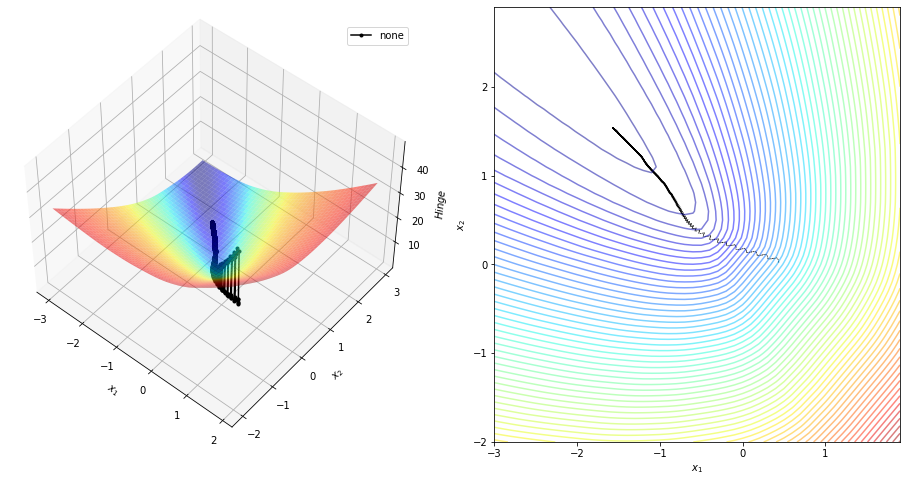

In [8]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, color='k', label='none')

In [9]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.549400     0.970     313    53
                10   0.639399     0.985     383    19
                100  0.364976     0.980     206    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

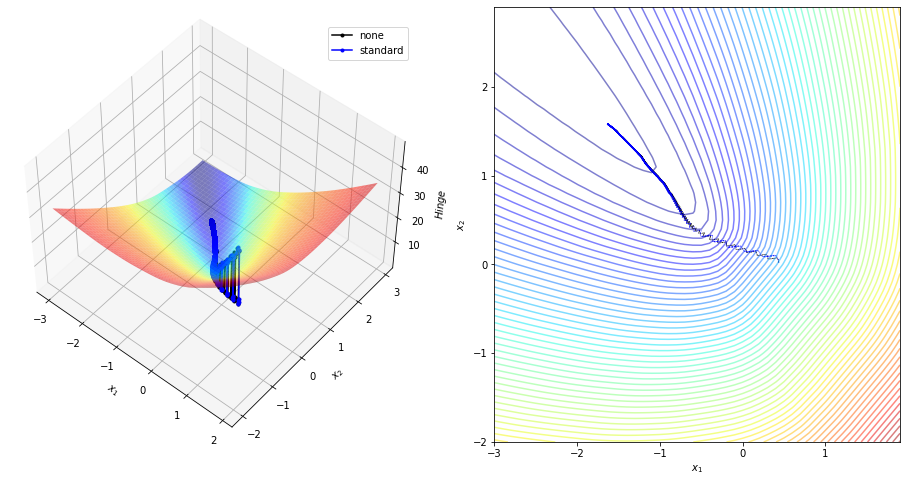

In [10]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='standard', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='standard')
hinge_loss_opt

In [11]:
standard_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.410322     0.970     228    48
                10   0.601464     0.985     295    16
                100  0.310293     0.980     123    11

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8e-04  5e-15
 6: -1.1843e+01 -1.2109e+01  3e-01  2e-05  6e-15
 7: -1.1951e+01 -1.1972e+01  2e-02  2e-06  5e-15
 8: -1.1960e+01 -1.1962e+01  2e-03  2e-16  6e-15
 9: -1.1961e+01 -1.1961e+01  2e-05  2e-16  6e-15
10: -1.1961e+01 -1.1961e+01  2e-07  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8628e+01 -4.0156e+02  2e+03  3e+00  2e-14
 1: -2.4099e+01 -2.2235e+02  4e+02  3e-01  1e-14
 2: -1.3880e+01 -4.8120e+01  6e+01  5e-02  1e-14
 3: -1.1134e+01 -2.1089e+01  1e+01  1e-02  8e-15
 4: -1.1231e+01 -1.5245e+01  5e+00  3e-03  6e-15
 5: -1.1547e+01 -1.3005e+01  2e+00  8

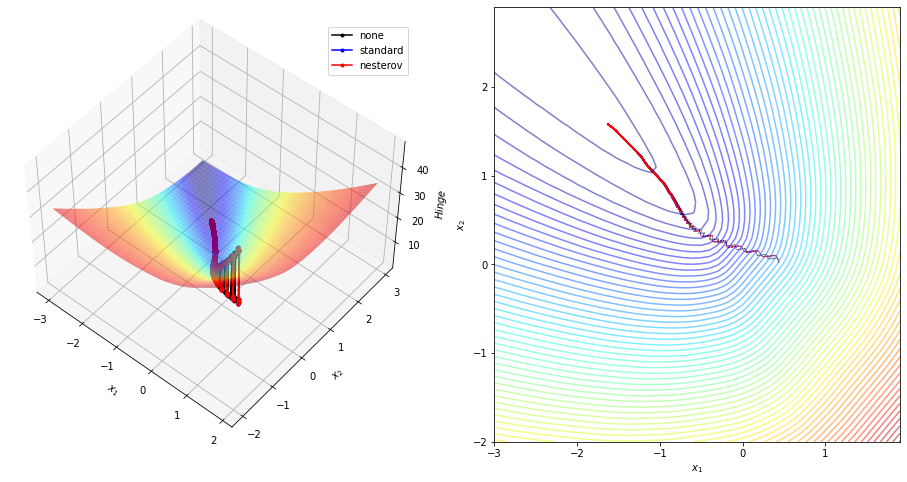

In [12]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='nesterov', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='nesterov')
hinge_loss_opt.savefig('./tex/img/l1_svc_loss.png')
hinge_loss_opt

In [13]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.419315     0.970     228    48
                10   0.489748     0.985     287    16
                100  0.267707     0.985     129    11

In [14]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(
    standard_primal_svc_hinge_cv_results).append(
    nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.549400     0.970     313    53
                10   0.639399     0.985     383    19
                100  0.364976     0.980     206    10
       standard 1    0.410322     0.970     228    48
                10   0.601464     0.985     295    16
                100  0.310293     0.980     123    11
       nesterov 1    0.419315     0.970     228    48
                10   0.489748     0.985     287    16
                100  0.267707     0.985     129    11

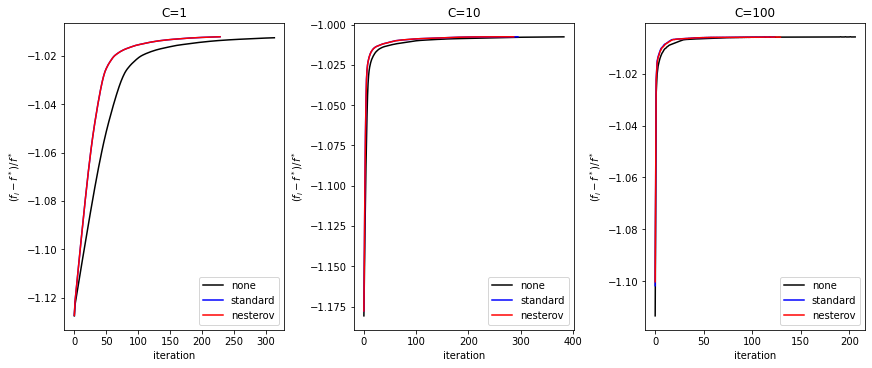

In [16]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('iteration')
        loss.set_ylabel('$\log{(f_i - f^*) / f^*}$')
        loss.yscale('log')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svc_loss_history.png')

In [16]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [17]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001720     0.985     332    15
                   10   0.001161     0.985     554     5
                   100  0.003379     0.985    1000     7

In [18]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_l1_svc.tex', 
                                     caption='Primal $\protect \mathcal{L}_1$-SVC results', 
                                     label='primal_l1_svc_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.472888     0.970     313    53
                   10   0.479242     0.985     383    19
                   100  0.259484     0.980     206    10
          standard 1    0.314042     0.970     228    48
                   10   0.370457     0.985     295    16
                   100  0.151304     0.980     123    11
          nesterov 1    0.292495     0.970     228    48
                   10   0.320098     0.985     287    16
                   100  0.161079     0.985     129    11
liblinear -        1    0.001720     0.985     332    15
                   10   0.001161     0.985     554     5
                   100  0.003379     0.985    1000     7

### Dual formulations

In [19]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [20]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [21]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history') and svc.optimizer.iter > 0:
        dual = 'reg_bias' if svc.fit_intercept else 'unreg_bias'
        train_loss_history[dual][svc.kernel.__class__.__name__][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


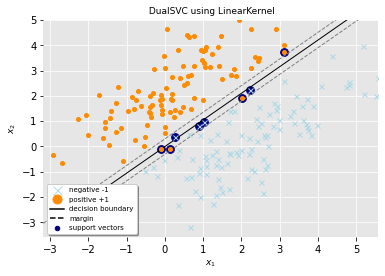

In [22]:
grid = GridSearchCV(DualSVC(loss=hinge, kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svc_hyperplane.png')

In [23]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
cvxopt 1    0.021248     0.980      10    17
       10   0.022844     0.980      10    11
       100  0.040131     0.980      10    12
smo    1    0.027854     0.980      62    17
       10   0.086635     0.980     295    10
       100  0.147432     0.985     399     8

In [24]:
grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [25]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
libsvm 1    0.002310     0.985     243    17
       10   0.002800     0.985     194    10
       100  0.002952     0.985    1602     8

In [26]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_l1_svc.tex', 
                                    caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                    label='linear_dual_l1_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
smo    1    0.027854     0.980      62    17
       10   0.086635     0.980     295    10
       100  0.147432     0.985     399     8
libsvm 1    0.002310     0.985     243    17
       10   0.002800     0.985     194    10
       100  0.002952     0.985    1602     8
cvxopt 1    0.021248     0.980      10    17
       10   0.022844     0.980      10    11
       100  0.040131     0.980      10    12

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


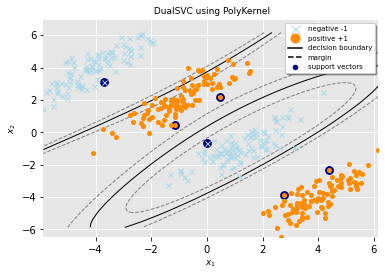

In [27]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svc_hyperplane.png')

In [28]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.249244    0.6775      10    31
              10   0.234898    0.9475      10    10
              100  0.167327    0.9775      10     6
smo    poly   1    0.328023    0.6825     143    30
              10   0.203539    0.9475      65    10
              100  0.112693    0.9775      38     6

Fitting 1 folds for each of 6 candidates, totalling 6 fits


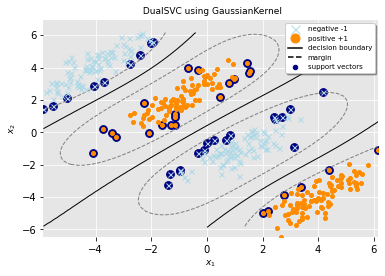

In [29]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svc_hyperplane.png')

In [30]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt rbf    1    0.221165       1.0      10    49
              10   0.223754       1.0      10    14
              100  0.196993       1.0      10    17
smo    rbf    1    0.362371       1.0      66    51
              10   0.150031       1.0      38    13
              100  0.242944       1.0      56    12

In [31]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.249244    0.6775      10    31
              10   0.234898    0.9475      10    10
              100  0.167327    0.9775      10     6
       rbf    1    0.221165    1.0000      10    49
              10   0.223754    1.0000      10    14
              100  0.196993    1.0000      10    17
smo    poly   1    0.328023    0.6825     143    30
              10   0.203539    0.9475      65    10
              100  0.112693    0.9775      38     6
       rbf    1    0.362371    1.0000      66    51
              10   0.150031    1.0000      38    13
              100  0.242944    1.0000      56    12

In [32]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [33]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
libsvm poly   1    0.007151       1.0     233    30
              10   0.002937       1.0     118    10
              100  0.005064       1.0      88     6
       rbf    1    0.004271       1.0     252    50
              10   0.004961       1.0     134    13
              100  0.003702       1.0     182    12

In [34]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svc.tex', 
                                       caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                       label='nonlinear_dual_l1_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
smo    poly   1    0.328023    0.6825     143    30
              10   0.203539    0.9475      65    10
              100  0.112693    0.9775      38     6
       rbf    1    0.362371    1.0000      66    51
              10   0.150031    1.0000      38    13
              100  0.242944    1.0000      56    12
libsvm poly   1    0.007151    1.0000     233    30
              10   0.002937    1.0000     118    10
              100  0.005064    1.0000      88     6
       rbf    1    0.004271    1.0000     252    50
              10   0.004961    1.0000     134    13
              100  0.003702    1.0000     182    12
cvxopt poly   1    0.249244    0.6775      10    31
              10   0.234898    0.9475      10    10
              100  0.167327    0.9775      10     6
       rbf    1    0.221165    1.0000      10    49
              10   0.223754    1.0000      10    14
              100  0.196993    1.0000      10    17

#### Lagrangian Dual

##### Linear

In [35]:
grid = GridSearchCV(DualSVC(loss=hinge, kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


In [36]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svc.tex', 
                                               caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                               label='linear_lagrangian_dual_l1_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                    
reg_bias   1    0.011619     0.985       1   194
           10   0.018497     0.985       1   194
           100  0.019863     0.985       1   194
unreg_bias 1    0.016800     0.985       1   195
           10   0.017489     0.985       1   195
           100  0.017297     0.985       1   195

##### Nonlinear

In [37]:
grid = GridSearchCV(DualSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


In [38]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svc.tex', 
                                                  caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                                  label='nonlinear_lagrangian_dual_l1_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                    
reg_bias   poly   1    1.229797     0.635     222   317
                  10   0.992484     0.635     222   317
                  100  0.871619     0.635     222   317
           rbf    1    0.111729     1.000       1   399
                  10   0.127928     1.000       1   399
                  100  0.089477     1.000       1   399
unreg_bias poly   1    0.023870     0.640       3   316
                  10   0.034400     0.640       3   316
                  100  0.039098     0.640       3   316
           rbf    1    0.186223     0.860       9   307
                  10   0.152077     0.860       9   307
                  100  0.144427     0.860       9   307

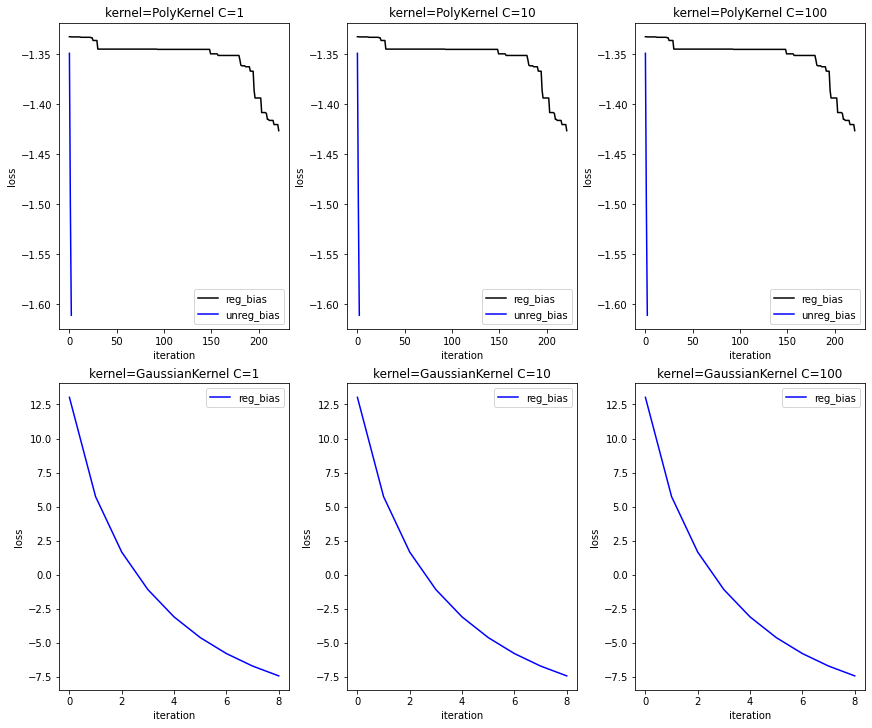

In [39]:
colors = {'reg_bias': 'k',
          'unreg_bias': 'b'}
axes = plt.figure(figsize=(12, 10), constrained_layout=True).subplots(2, 3)  # figsize (12, 15) and subplots (3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual])
            loss.set_title('kernel={} C={:d}'.format(kernel, C))
            loss.set_xlabel('iteration')
            loss.set_ylabel('\log{(f_i - f^*) / f^*}')
            loss.yscale('log')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l1_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [17]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [18]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import linear
        
        dual_svc = DualSVC(loss=squared_hinge, kernel=linear, C=svc.C, fit_intercept=svc.fit_intercept, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, dual_svc.obj(dual_svc.alphas_))
        # (f_i - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), f_star)
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

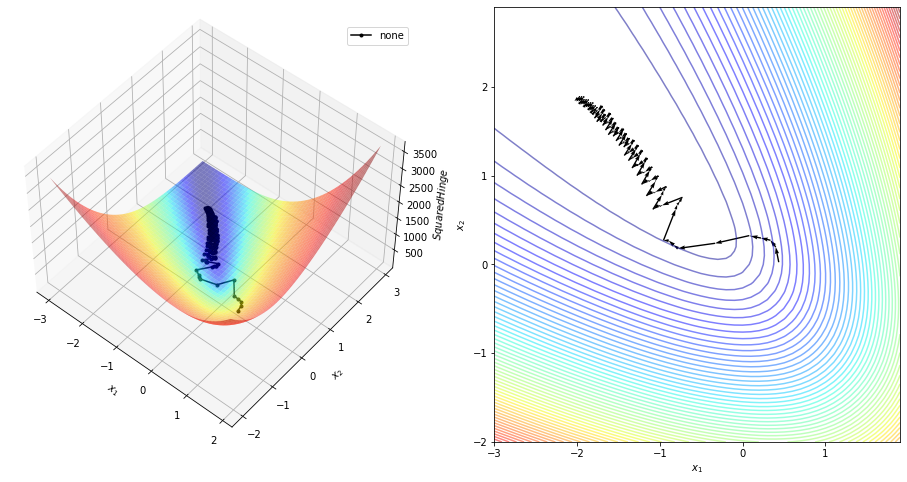

In [19]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='none')

In [20]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.319778     0.975     154    49
                10   0.244435     0.980     119    24
                100  0.127717     0.985      30    15

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

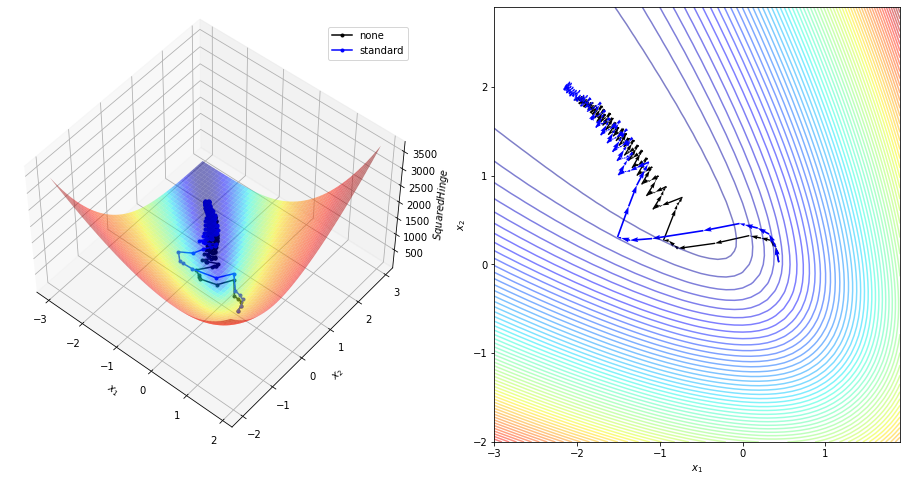

In [21]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='standard')
squared_hinge_loss_opt

In [22]:
standard_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.278139     0.975     113    45
                10   0.169913     0.980      73    24
                100  0.099706     0.985      21    11

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1621e+01 -4.9136e+01  5e+02  2e+01  2e+00
 1: -2.7460e+01 -2.8540e+01  7e+01  3e+00  2e-01
 2: -1.5534e+01 -1.3489e+01  8e+00  4e-01  3e-02
 3: -1.1267e+01 -1.1570e+01  1e+00  2e-02  2e-03
 4: -1.1197e+01 -1.1253e+01  9e-02  1e-03  9e-05
 5: -1.1227e+01 -1.1231e+01  5e-03  4e-05  3e-06
 6: -1.1230e+01 -1.1230e+01  2e-04  6e-07  5e-08
 7: -1.1230e+01 -1.1230e+01  2e-06  6e-09  5e-10
Optimal solution found.
     pcost   

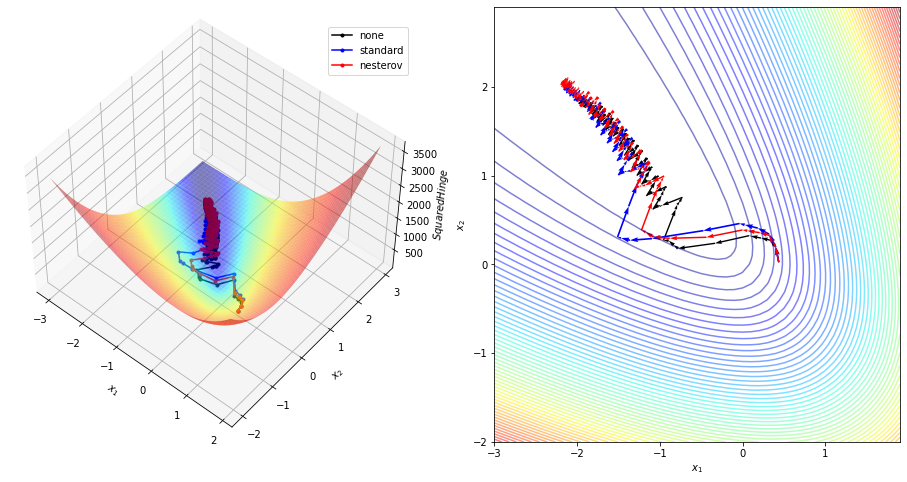

In [23]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/l2_svc_loss.png')
squared_hinge_loss_opt

In [24]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.286867     0.970     132    40
                10   0.193969     0.980      71    23
                100  0.098214     0.985      26    10

In [25]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(
    standard_primal_svc_squared_hinge_cv_results).append(
    nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.319778     0.975     154    49
                10   0.244435     0.980     119    24
                100  0.127717     0.985      30    15
       standard 1    0.278139     0.975     113    45
                10   0.169913     0.980      73    24
                100  0.099706     0.985      21    11
       nesterov 1    0.286867     0.970     132    40
                10   0.193969     0.980      71    23
                100  0.098214     0.985      26    10

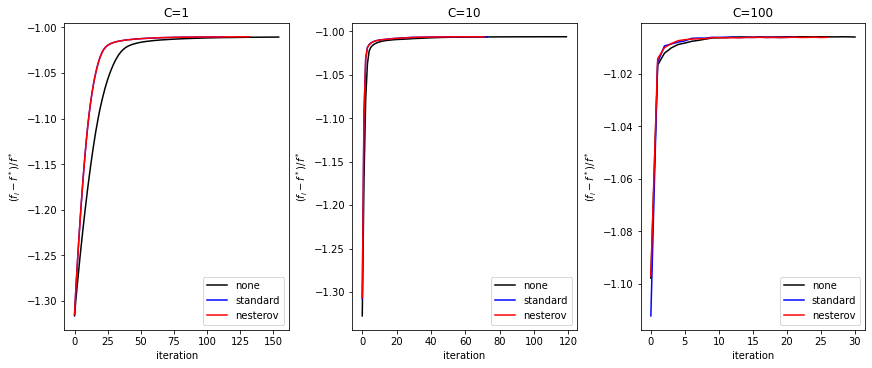

In [26]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('iteration')
        loss.set_ylabel('\log{(f_i - f^*) / f^*}')
        loss.yscale('log')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svc_loss_history.png')

In [50]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [51]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001436      0.98     556    25
                   10   0.002819      0.98    1000    19
                   100  0.002577      0.98    1000    27

In [52]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_l2_svc.tex', 
                                             caption='Primal $\protect \mathcal{L}_2$-SVC results', 
                                             label='primal_l2_svc_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.229720     0.975     154    49
                   10   0.170512     0.980     119    24
                   100  0.045986     0.985      30    15
          standard 1    0.182178     0.975     113    45
                   10   0.111240     0.980      73    24
                   100  0.032451     0.985      21    11
          nesterov 1    0.178075     0.970     132    40
                   10   0.096167     0.980      71    23
                   100  0.036805     0.985      26    10
liblinear -        1    0.001436     0.980     556    25
                   10   0.002819     0.980    1000    19
                   100  0.002577     0.980    1000    27

### Dual formulations

In [53]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [54]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history') and svc.optimizer.iter > 0:
        dual = 'reg_bias' if svc.fit_intercept else 'unreg_bias'
        train_loss_history[dual][svc.kernel.__class__.__name__][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': (svc.iter if isinstance(svc.optimizer, str) else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Lagrangian Dual

##### Linear

In [55]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


In [56]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l2_svc.tex', 
                                               caption='Lagrangian Dual linear $\protect \mathcal{L}_2$-SVC results', 
                                               label='linear_lagrangian_dual_l2_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                    
reg_bias   1    0.082991     0.985       1   200
           10   0.044103     0.975       1   200
           100  0.052193     0.985       1   200
unreg_bias 1    0.849253     0.975    1000    61
           10   0.693914     0.985    1000   200
           100  0.997513     0.975    1000   200

##### Nonlinear

In [57]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


In [58]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l2_svc.tex', 
                                                  caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_2$-SVC results', 
                                                  label='nonlinear_lagrangian_dual_l2_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                    
reg_bias   poly   1    0.067146    0.5000       1   400
                  10   0.054950    0.5025       1   400
                  100  0.049703    0.5000       1   400
           rbf    1    0.036859    0.8300       1   400
                  10   0.078451    0.7750       1   400
                  100  0.066954    0.8975       1   400
unreg_bias poly   1    2.249363    0.5000    1000   323
                  10   2.188390    0.5000    1000   400
                  100  2.319611    0.5000    1000   400
           rbf    1    0.132964    0.7050      21   223
                  10   1.616924    0.8750    1000   400
                  100  1.315613    0.8350    1000   400

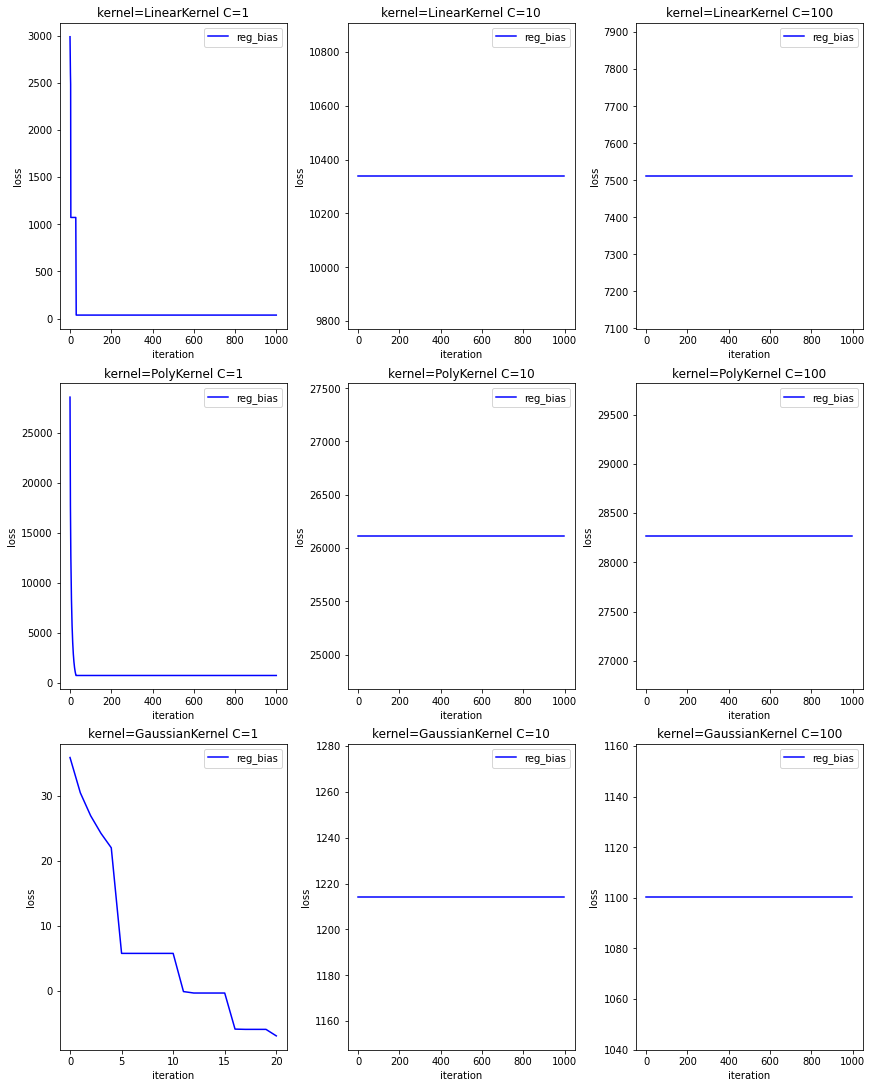

In [59]:
colors = {'reg_bias': 'k',
          'unreg_bias': 'b'}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual])
            loss.set_title('kernel={} C={:d}'.format(kernel, C))
            loss.set_xlabel('iteration')
            loss.set_ylabel('\log{(f_i - f^*) / f^*}')
            loss.yscale('log')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l2_svc_loss_history.png')